In [1]:
#Previamente Instalar: transformers, datasets, wandb, torch
%pip install datasets
%pip install transformers
%pip install wandb
%pip install torch
%pip install evaluate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#Realizamos los imports necesarios
import os
import logging

import numpy as np

from dataclasses import dataclass
from typing import Dict, List, Optional, Union

import torch
import wandb

from datasets import DatasetDict, load_from_disk
from transformers import (
    HubertForSequenceClassification,
    HubertConfig,
    Trainer,
    TrainingArguments,
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Processor,
    EarlyStoppingCallback,
    IntervalStrategy
)


logging.basicConfig(
    format="%(asctime)s | %(levelname)s: %(message)s", level=logging.INFO
)

c:\Users\albii\OneDrive\Escritorio\ALBA\4\TFG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
USER = "100429064"
WANDB_PROJECT = "SER-Project"
wandb.init(entity=USER, project=WANDB_PROJECT)

2023-09-05 01:07:34,171 | ERROR: Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 100429064. Use `wandb login --relogin` to force relogin


In [4]:
PROJECT_ROOT = 'C:/Users/albii/OneDrive/Escritorio/ALBA/4/TFG/'

NUM_LABELS = 12

In [5]:
model_id = "facebook/hubert-base-ls960"
#model_id = os.path.join(PROJECT_ROOT, "models_early/audio-model")
MODELS_DIR = os.path.join(PROJECT_ROOT, "models_oficiales")


In [6]:
#Cargando modelo preentrenado

config2 = HubertConfig.from_pretrained(model_id, num_labels=NUM_LABELS)

hubert_model = HubertForSequenceClassification.from_pretrained(
    model_id,
    config=config2,  # because we need to update num_labels as per our dataset
    ignore_mismatched_sizes=True  # to avoid classifier size mismatch from from_pretrained.
)


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['projector.bias', 'classifier.bias', 'projector.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
#Unfreezing layers for fine-tuning

# unfreeze all layers to begin with
for param in hubert_model.parameters():
    param.requires_grad = False


layers_freeze_num = 2
n_layers = (
    4 + layers_freeze_num * 16
)  # 4 refers to projector and classifier's weights and biases.
for name, param in list(hubert_model.named_parameters())[-n_layers:]:
    param.requires_grad = True

In [8]:
#Cargamos el datast
ds = load_from_disk(PROJECT_ROOT + 'datasets')

In [9]:
wandb.log({"dataset_size": len(ds["train"])})

In [10]:
#Preparamos la configuracion del entrenamiento
trainer_config = {
  "OUTPUT_DIR": "results_oficiales",
  "TRAIN_EPOCHS": 5,
  "TRAIN_BATCH_SIZE": 32,
  "EVAL_BATCH_SIZE": 32,
  "GRADIENT_ACCUMULATION_STEPS": 4,
  "WARMUP_STEPS": 500,
  "DECAY": 0.01,
  "LOGGING_STEPS": 10,
  "MODEL_DIR": "models_oficiales/audio-model",
  "SAVE_STEPS": 50,
  "LR":1e-3
}

'''
trainer_config = {
    "OUTPUT_DIR": "results_ravdess3",
    "TRAIN_EPOCHS": 5,
    "TRAIN_BATCH_SIZE": 32,
    "EVAL_BATCH_SIZE": 32,
    "GRADIENT_ACCUMULATION_STEPS": 4,
    "WARMUP_STEPS": 500,
    "DECAY": 0.01,
    "LOGGING_STEPS": 10,
    "MODEL_DIR": "models_ravdess3/audio-model",
    "LR": 1e-3,
}'''

'\ntrainer_config = {\n    "OUTPUT_DIR": "results_ravdess3",\n    "TRAIN_EPOCHS": 5,\n    "TRAIN_BATCH_SIZE": 32,\n    "EVAL_BATCH_SIZE": 32,\n    "GRADIENT_ACCUMULATION_STEPS": 4,\n    "WARMUP_STEPS": 500,\n    "DECAY": 0.01,\n    "LOGGING_STEPS": 10,\n    "MODEL_DIR": "models_ravdess3/audio-model",\n    "LR": 1e-3,\n}'

In [11]:
# INTRODUCE TRAIN TEST VAL SPLITS

# 90% train, 10% test + validation
train_testvalid = ds["train"].train_test_split(shuffle=True, test_size=0.1)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'val': test_valid['train']})

In [12]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['file', 'label', 'array', 'input_values', 'labels'],
        num_rows: 1467
    })
    test: Dataset({
        features: ['file', 'label', 'array', 'input_values', 'labels'],
        num_rows: 82
    })
    val: Dataset({
        features: ['file', 'label', 'array', 'input_values', 'labels'],
        num_rows: 82
    })
})


In [13]:
# Fine-Tuning with Trainer
training_args = TrainingArguments(
   f"training_with_callbacks",
   evaluation_strategy = IntervalStrategy.STEPS, # "steps"
   eval_steps = 50, # Evaluation and Save happens every 50 steps
   save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
   learning_rate=trainer_config["LR"],
   per_device_train_batch_size=trainer_config["TRAIN_BATCH_SIZE"],  
    # batch size per device during training
   per_device_eval_batch_size=trainer_config["EVAL_BATCH_SIZE"],  
    # batch size for evaluation
   num_train_epochs=trainer_config["TRAIN_EPOCHS"],  
    # total number of training epochs
   report_to="wandb",
   weight_decay=trainer_config["DECAY"],  # strength of weight decay
   push_to_hub=False,
   metric_for_best_model = 'f1',
   load_best_model_at_end=True)

'''
training_args = TrainingArguments(
    output_dir=os.path.join(
        PROJECT_ROOT, trainer_config["OUTPUT_DIR"]
    ),  # output directory
    gradient_accumulation_steps=trainer_config[
        "GRADIENT_ACCUMULATION_STEPS"
    ],  # accumulate the gradients before running optimization step
    num_train_epochs=trainer_config["TRAIN_EPOCHS"],  # total number of training epochs
    per_device_train_batch_size=trainer_config[
        "TRAIN_BATCH_SIZE"
    ],  # batch size per device during training
    per_device_eval_batch_size=trainer_config[
        "EVAL_BATCH_SIZE"
    ],  # batch size for evaluation
    warmup_steps=trainer_config[
        "WARMUP_STEPS"
    ],  # number of warmup steps for learning rate scheduler
    weight_decay=trainer_config["DECAY"],  # strength of weight decay
    logging_steps=trainer_config["LOGGING_STEPS"],
    evaluation_strategy="epoch",  # report metric at end of each epoch
    report_to="wandb",  # enable logging to W&B
    learning_rate=trainer_config["LR"],  # default = 5e-5
)'''

'\ntraining_args = TrainingArguments(\n    output_dir=os.path.join(\n        PROJECT_ROOT, trainer_config["OUTPUT_DIR"]\n    ),  # output directory\n    gradient_accumulation_steps=trainer_config[\n        "GRADIENT_ACCUMULATION_STEPS"\n    ],  # accumulate the gradients before running optimization step\n    num_train_epochs=trainer_config["TRAIN_EPOCHS"],  # total number of training epochs\n    per_device_train_batch_size=trainer_config[\n        "TRAIN_BATCH_SIZE"\n    ],  # batch size per device during training\n    per_device_eval_batch_size=trainer_config[\n        "EVAL_BATCH_SIZE"\n    ],  # batch size for evaluation\n    warmup_steps=trainer_config[\n        "WARMUP_STEPS"\n    ],  # number of warmup steps for learning rate scheduler\n    weight_decay=trainer_config["DECAY"],  # strength of weight decay\n    logging_steps=trainer_config["LOGGING_STEPS"],\n    evaluation_strategy="epoch",  # report metric at end of each epoch\n    report_to="wandb",  # enable logging to W&B\n   

In [14]:
@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(
        self, examples: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:

        input_features = [
            {INPUT_FIELD: example[INPUT_FIELD]} for example in examples
        ]  # example is basically row0, row1, etc...
        labels = [example[LABEL_FIELD] for example in examples]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        batch[LABEL_FIELD] = torch.tensor(labels)

        return batch
    
from datasets import load_metric
import evaluate 

def compute_metrics(eval_pred):
    # DEFINE EVALUATION METRIC
    compute_f1_metric = evaluate.load('f1', average='macro')
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return compute_f1_metric.compute(predictions=predictions, references=labels, average='macro')

'''
def compute_metrics(eval_pred):
    # DEFINE EVALUATION METRIC
    compute_accuracy_metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return compute_accuracy_metric.compute(predictions=predictions, references=labels)'''


'\ndef compute_metrics(eval_pred):\n    # DEFINE EVALUATION METRIC\n    compute_accuracy_metric = load_metric("accuracy")\n    logits, labels = eval_pred\n    predictions = np.argmax(logits, axis=-1)\n    return compute_accuracy_metric.compute(predictions=predictions, references=labels)'

In [15]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")

data_collator = DataCollatorCTCWithPadding(
            processor=feature_extractor,
            padding=True
)

In [16]:
# START TRAINING
INPUT_FIELD = "input_values"
LABEL_FIELD = "labels"

'''trainer = Trainer(
    model=hubert_model,  
    args=training_args,  # training arguments, defined above
    data_collator=data_collator,
    train_dataset=ds["train"],  # training dataset
    eval_dataset=ds["val"],  # evaluation dataset
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience = 10)]
)'''

trainer = Trainer(
    model=hubert_model,  
    args=training_args,  # training arguments, defined above
    data_collator=data_collator,
    train_dataset=ds["train"],  # training dataset
    eval_dataset=ds["val"],  # evaluation dataset
    compute_metrics=compute_metrics,
)

trainer.train()

c:\Users\albii\OneDrive\Escritorio\ALBA\4\TFG\.venv\Lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
                                                  
 22%|██▏       | 50/230 [30:01<1:43:54, 34.64s/it]

{'eval_loss': 1.8382630348205566, 'eval_f1': 0.06158357771260998, 'eval_runtime': 47.7315, 'eval_samples_per_second': 1.718, 'eval_steps_per_second': 0.063, 'epoch': 1.09}


                                                   
 43%|████▎     | 100/230 [58:17<1:08:35, 31.65s/it]

{'eval_loss': 1.866574764251709, 'eval_f1': 0.06158357771260998, 'eval_runtime': 43.734, 'eval_samples_per_second': 1.875, 'eval_steps_per_second': 0.069, 'epoch': 2.17}


                                                     
 65%|██████▌   | 150/230 [1:26:41<45:24, 34.06s/it]

{'eval_loss': 1.8027015924453735, 'eval_f1': 0.06158357771260998, 'eval_runtime': 43.44, 'eval_samples_per_second': 1.888, 'eval_steps_per_second': 0.069, 'epoch': 3.26}


                                                     
 87%|████████▋ | 200/230 [1:54:57<16:36, 33.22s/it]

{'eval_loss': 1.786604881286621, 'eval_f1': 0.06158357771260998, 'eval_runtime': 44.0315, 'eval_samples_per_second': 1.862, 'eval_steps_per_second': 0.068, 'epoch': 4.35}


100%|██████████| 230/230 [2:11:11<00:00, 34.22s/it]

{'train_runtime': 7871.0266, 'train_samples_per_second': 0.932, 'train_steps_per_second': 0.029, 'train_loss': 2.090205715013587, 'epoch': 5.0}


TrainOutput(global_step=230, training_loss=2.090205715013587, metrics={'train_runtime': 7871.0266, 'train_samples_per_second': 0.932, 'train_steps_per_second': 0.029, 'train_loss': 2.090205715013587, 'epoch': 5.0})

In [17]:
# VALIDATION SET RESULTS
logging.info("Eval Set Result: {}".format(trainer.evaluate()))

100%|██████████| 3/3 [00:26<00:00,  8.78s/it]
2023-09-05 03:19:33,750 | INFO: Eval Set Result: {'eval_loss': 1.789774775505066, 'eval_f1': 0.06158357771260998, 'eval_runtime': 42.5046, 'eval_samples_per_second': 1.929, 'eval_steps_per_second': 0.071, 'epoch': 5.0}


In [19]:
# TEST RESULTS
test_results = trainer.predict(ds["test"])
logging.info("Test Set Result: {}".format(test_results.metrics))
wandb.log({"test_f1": test_results.metrics["test_f1"]})

trainer.save_model(os.path.join(PROJECT_ROOT, trainer_config["MODEL_DIR"]))



100%|██████████| 3/3 [00:22<00:00,  7.47s/it]
2023-09-05 09:36:23,224 | INFO: Test Set Result: {'test_loss': 1.8224576711654663, 'test_f1': 0.06333333333333334, 'test_runtime': 36.8426, 'test_samples_per_second': 2.226, 'test_steps_per_second': 0.081}


In [20]:
y_pred = np.argmax(test_results.predictions, axis=-1)
y_true = test_results.label_ids

In [21]:
print(ds['test']['file'])
print(y_true)


['/home/cmramirez/Desktop/Python/Alba/toDataset/cache_crema/downloads/extracted/8fb6db4bc114ea36fbb3059ee0c886de0c1bc4f6512d1198e2c7b936b51c48e7/AudioWAV/P011_VIDEO_3_CHUNK_8.wav', '/home/cmramirez/Desktop/Python/Alba/toDataset/cache_crema/downloads/extracted/8fb6db4bc114ea36fbb3059ee0c886de0c1bc4f6512d1198e2c7b936b51c48e7/AudioWAV/V098_VIDEO_14_CHUNK_8.wav', '/home/cmramirez/Desktop/Python/Alba/toDataset/cache_crema/downloads/extracted/8fb6db4bc114ea36fbb3059ee0c886de0c1bc4f6512d1198e2c7b936b51c48e7/AudioWAV/V082_VIDEO_6_CHUNK_2.wav', '/home/cmramirez/Desktop/Python/Alba/toDataset/cache_crema/downloads/extracted/8fb6db4bc114ea36fbb3059ee0c886de0c1bc4f6512d1198e2c7b936b51c48e7/AudioWAV/V088_VIDEO_10_CHUNK_4.wav', '/home/cmramirez/Desktop/Python/Alba/toDataset/cache_crema/downloads/extracted/8fb6db4bc114ea36fbb3059ee0c886de0c1bc4f6512d1198e2c7b936b51c48e7/AudioWAV/V115_VIDEO_2_CHUNK_3.wav', '/home/cmramirez/Desktop/Python/Alba/toDataset/cache_crema/downloads/extracted/8fb6db4bc114ea36fb


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (11).

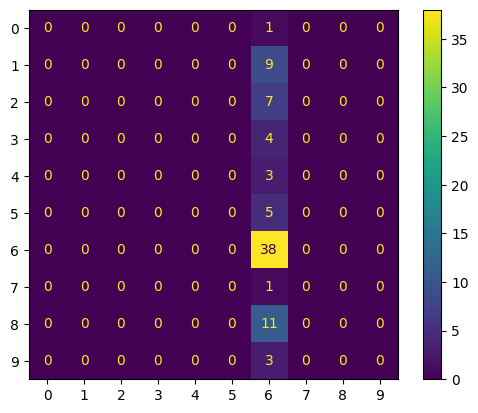

In [23]:
%pip install matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = ['Ab','Aleg','Asc','Atrac','Desp',
                                                              'Esp','Grat', 'Ira', 'Mied'
                                                              'Sorp', 'Tranq', 'Tris'])

cm_display.plot()
plt.savefig(PROJECT_ROOT + 'MatrizConfusion_oficial.png')
plt.show()


In [24]:
wandb.save(PROJECT_ROOT + trainer_config["MODEL_DIR"], policy="end")
wandb.run.finish()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


dataset_size,▁
eval/f1,▁▁▁▁▁
eval/loss,▆█▂▁▁
eval/runtime,█▃▂▃▁
eval/samples_per_second,▁▆▇▆█
eval/steps_per_second,▁▆▆▅█
test_f1,▁
train/epoch,▁▃▅▇██
train/global_step,▁▃▅▇███
train/total_flos,▁
train/train_loss,▁


In [25]:
accuracy = load_metric("accuracy").compute(predictions=y_pred, references=y_true)
#f1 = load_metric("f1").compute(predictions=y_pred, references=y_true, average = 'macro')  
recall = load_metric("recall").compute(predictions=y_pred, references=y_true, average = 'macro')
precision = load_metric("precision").compute(predictions=y_pred, references=y_true, average = 'macro')

print(accuracy, recall, precision)

C:\Users\albii\AppData\Local\Temp\ipykernel_17516\416743513.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy = load_metric("accuracy").compute(predictions=y_pred, references=y_true)


{'accuracy': 0.4634146341463415} {'recall': 0.1} {'precision': 0.046341463414634146}


c:\Users\albii\OneDrive\Escritorio\ALBA\4\TFG\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
